In [11]:
import numpy as np
import qilisdk
import qutip as qt
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')

import hamiltonian
import dynamics
import plots
import estimator
import VQE

from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, M, U1, CNOT, U2, U3, CZ, RX, RZ, H
from qilisdk.functionals.sampling import Sampling, SamplingResult
from qilisdk.functionals.time_evolution import TimeEvolution
from scipy.optimize import minimize

from qilisdk.analog import Schedule, X, Z, Y
from qilisdk.core import ket, tensor_prod
from qilisdk.backends import QutipBackend, CudaBackend
from qilisdk.functionals import TimeEvolution

## Generate Hamiltonian

In [12]:
nqubits = 6
connectivity = "nearest-neighbours"

# target_weights = [0.5, 0.8, 0.1, 0.4, 0.5, 0.1, 0.6, 0.8]
# H_target = hamiltonian.create_hamiltonian_from_weights(nqubits, target_weights, connectivity)
min_w = -1
max_w = 1
H_target, target_weights = hamiltonian.create_random_hamiltonian(nqubits, min_w, max_w, connectivity, backend='qilisdk')


print("Target Hamilonian: \n", H_target.H, "\n")
print("Target weights:", target_weights)

Target Hamilonian: 
 0.35635590137834816 X(0) + 0.9147480082298645 Z(0) + 0.771831380645787 X(1) + 0.07739225514860792 Z(1) - 0.7140439586745855 X(2) + 0.9546760650779502 Z(2) - 0.05489575341254915 X(3) - 0.7730948653804435 Z(3) - 0.33802449228226217 X(4) + 0.4363953693178473 Z(4) + 0.22846334937380242 X(5) + 0.48026690509636105 Z(5) + 0.2694173627206087 Z(0) Z(1) - 0.6324534355858524 Z(1) Z(2) + 0.2841350748983602 Z(2) Z(3) + 0.15374661175270443 Z(3) Z(4) - 0.4211037017099999 Z(4) Z(5) 

Target weights: [ 0.3563559   0.77183138 -0.71404396 -0.05489575 -0.33802449  0.22846335
  0.91474801  0.07739226  0.95467607 -0.77309487  0.43639537  0.48026691
  0.26941736 -0.63245344  0.28413507  0.15374661 -0.4211037 ]


## Create target trajectory

In [13]:
ti = 0
times = np.linspace(0.01, 3, 20)

initial_zero_state = tensor_prod([ket(0).unit() for _ in range(nqubits)]).unit()
initial_minus_state = tensor_prod([(ket(0) - ket(1)).unit() for _ in range(nqubits)]).unit()

Hx = sum(X(i) for i in range(nqubits)) #Driver

target_states = []
target_x, target_y, target_z = [], [], []
T_final = times[-1]
for T in times:
    dt = T/100
    steps = np.linspace(0, T, int(T / dt))
    sim = VQE.simulate_annealing(T, dt, T_final, steps, Hx, H_target.H, initial_zero_state)
    #save expectation values
    target_x.append(sim.final_expected_values[0])
    target_y.append(sim.final_expected_values[1])
    target_z.append(sim.final_expected_values[2])

    #save final state as qutip object
    target_state_data = sim.final_state.data
    target_state_array = target_state_data.toarray()
    target_qutip_state = qt.Qobj(target_state_array, dims=[[2]*nqubits, [1]])

    target_states.append(target_qutip_state)

In [14]:
# Define Hamiltonians
alpha = 1.

if connectivity == "all-to-all":
    initial_weights = np.random.uniform(min_w, max_w, size=(2*nqubits + int(nqubits*(nqubits-1)/2)))
elif connectivity == "nearest-neighbours":
    initial_weights = np.random.uniform(min_w, max_w, size=(3*nqubits -1))

options={
    'maxiter': 2000,           # Increase iterations
    'ftol': 1e-10,            # Function tolerance
    'gtol': 1e-8,             # Gradient tolerance  
    'maxfun': 10000,          # Max function evaluations
    'disp': True              # Print convergence messages
    }

alphas = np.linspace(1, 0, 1)
losses = []
leraned_parameters = []
observables = [target_x, target_y, target_z]

print("target_weights:", target_weights)
print("initial_weights:", initial_weights)
for alpha in alphas:
    print("Alpha = ", alpha)
    final_result = VQE.learn_hamiltonian(nqubits, initial_weights, Hx, initial_zero_state, target_states, times, connectivity, alpha, observables = observables, optimizer_options = options, mode = "segmented")
    print("Loss = ", final_result.fun)
    print("Params:", final_result.x)
    losses.append(final_result.fun)
    leraned_parameters.append(final_result.x)

target_weights: [ 0.3563559   0.77183138 -0.71404396 -0.05489575 -0.33802449  0.22846335
  0.91474801  0.07739226  0.95467607 -0.77309487  0.43639537  0.48026691
  0.26941736 -0.63245344  0.28413507  0.15374661 -0.4211037 ]
initial_weights: [ 0.99900689  0.57979706  0.62205958  0.31180226  0.71983277 -0.227654
 -0.39295791  0.9823568   0.11137199  0.49051271  0.01879338 -0.35977737
  0.96527853  0.89007594 -0.94801423 -0.26375753 -0.89958936]
Alpha =  1.0
Loss =  3.692163744850596e-06
Params: [ 0.35621828  0.77160012 -0.71146684 -0.05533551 -0.34043992  0.22865763
  0.9139096   0.0755659   0.95419158 -0.77213922  0.43498785  0.47511212
  0.26874178 -0.63308438  0.28358792  0.15447461 -0.42505617]


3.692163744850596e-06


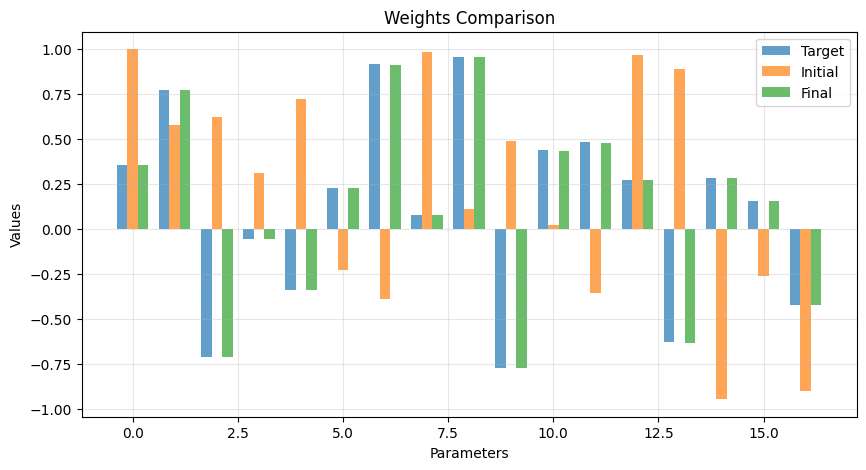

In [15]:
print(final_result.fun)
final_weights = final_result.x
plots.plot_weights(target_weights, initial_weights, final_weights)